In [3]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def read_images_in_folder(folder_path):
    image_array = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):
            image_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(image_path)
                img = img.resize(size=(256,256))
                img = np.array(img) / 255.0
                image_array.append(np.array(img).reshape(256,256,3))
            except IOError:
                print(f"Failed to open image: {image_path}")
    return np.array(image_array)
folder_path = '/content/drive/MyDrive/ColTran_dataset/'
color_images = read_images_in_folder(folder_path)

In [5]:
print(type(color_images))
color_images.shape

<class 'numpy.ndarray'>


(88, 256, 256, 3)

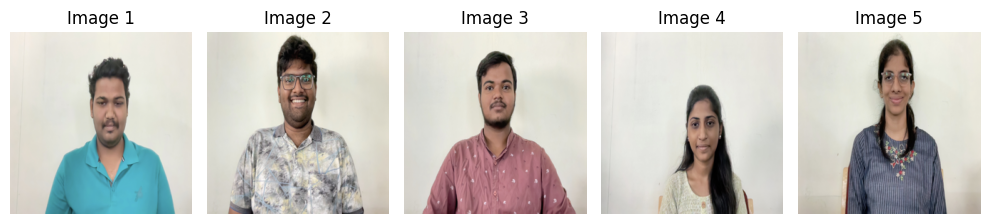

In [6]:
if isinstance(color_images, np.ndarray):
    if color_images.ndim == 4:
        plt.figure(figsize=(10, 6))
        for i in range(min(5, color_images.shape[0])):
            plt.subplot(1, 5, i + 1)
            plt.imshow(color_images[i])
            plt.axis('off')
            plt.title(f"Image {i + 1}")

        plt.tight_layout()
        plt.show()
    else:
        print("The provided NumPy array 'images' does not have the expected shape for displaying multiple images.")
else:
    print("The variable 'images' is not a NumPy array.")

In [7]:
def convert_to_grayscale(images):
    # Converting colorImages(RGB) to grayscale(luminance) using weighted averages
    # Luminance=0.299*R+0.587*G+0.114*B
    grayscale_images = np.dot(images[..., :3], [0.299, 0.587, 0.114])
    if grayscale_images.ndim == 3:
        grayscale_images = grayscale_images[..., np.newaxis]
    return grayscale_images
grey_images = convert_to_grayscale(color_images)

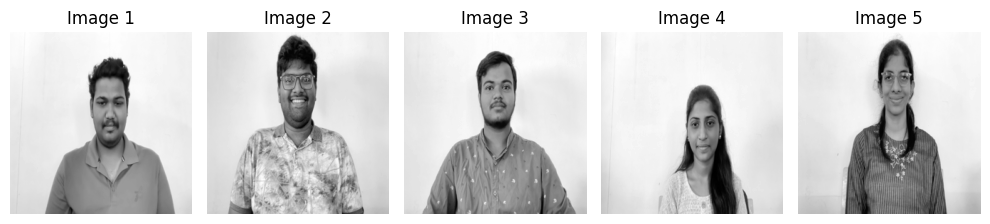

In [32]:
# Displaying first five gray images
if isinstance(grey_images, np.ndarray) and grey_images.ndim == 4:
    plt.figure(figsize=(10, 6))
    for i in range(min(5, grey_images.shape[0])):
        plt.subplot(1, 5, i + 1)
        plt.imshow(grey_images[i], cmap='gray')
        plt.axis('off')
        plt.title(f"Image {i + 1}")
    plt.tight_layout()
    plt.show()
else:
    print("The input is not a 4D NumPy array.")

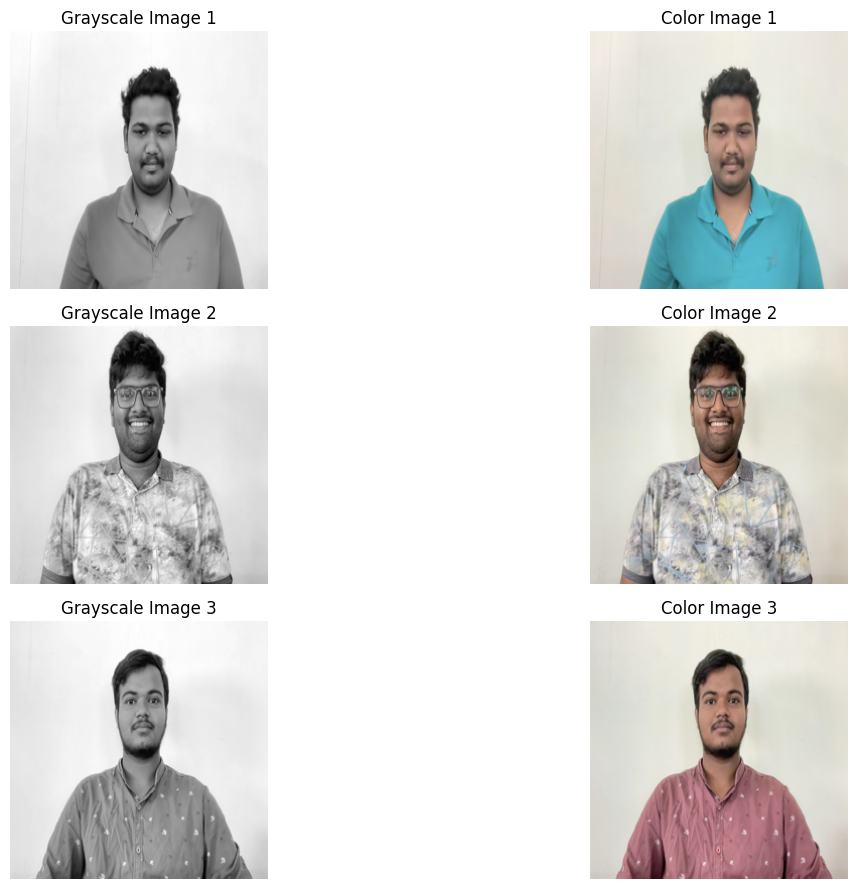

In [10]:
if isinstance(color_images, np.ndarray) and isinstance(grey_images, np.ndarray):
    if color_images.shape[0] >= 3 and grey_images.shape[0] >= 3:
        plt.figure(figsize=(15, 9))
        for i in range(3):
            plt.subplot(3, 2, 2*i + 1)
            plt.imshow(grey_images[i], cmap='gray')
            plt.axis('off')
            plt.title(f"Grayscale Image {i + 1}")

            plt.subplot(3, 2, 2*i + 2)
            plt.imshow(color_images[i])
            plt.axis('off')
            plt.title(f"Color Image {i + 1}")
        plt.tight_layout()
        plt.show()
    else:
        print("There are insufficient images in the provided NumPy arrays to display.")
else:
    print("The variables are not NumPy arrays.")


In [13]:
from sklearn.model_selection import train_test_split
train_X,test_X,train_Y, test_Y= train_test_split(grey_images,color_images,test_size=0.3, random_state=42)
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, InputLayer, Flatten, Reshape, BatchNormalization, MaxPooling2D, UpSampling2D

In [14]:
s=256
z_dim = 100

# ENCODER

encoder = Sequential()
encoder.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(s, s, 1)))
encoder.add(BatchNormalization())
encoder.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
encoder.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
encoder.add(BatchNormalization())
req_shape = encoder.output_shape
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 250, 250, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 250, 250, 64)      256       
 chNormalization)                                                
                                                                 
Total params: 23616 (92.25 KB)
Trainable params: 23456 (

In [16]:
# DECODER

decoder = Sequential()
decoder.add(Conv2DTranspose(filters=64, kernel_size=3, activation = 'relu',input_shape=req_shape[1:]))
decoder.add(BatchNormalization())
decoder.add(Conv2DTranspose(filters=32, kernel_size=3, activation = 'relu'))
decoder.add(BatchNormalization())
decoder.add(Conv2DTranspose(filters=3, kernel_size=3, activation = 'sigmoid'))
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 252, 252, 64)      36928     
 anspose)                                                        
                                                                 
 batch_normalization_2 (Bat  (None, 252, 252, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 254, 254, 32)      18464     
 Transpose)                                                      
                                                                 
 batch_normalization_3 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 256, 256, 3)      

In [18]:
autoencoder=Sequential()
autoencoder.add(encoder)
# autoencoder.add(Dense(np.prod(req_shape[1:])))
# autoencoder.add(Reshape(req_shape[1:]))
autoencoder.add(decoder)
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 250, 250, 64)      23616     
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       56643     
                                                                 
Total params: 80259 (313.51 KB)
Trainable params: 79907 (312.14 KB)
Non-trainable params: 352 (1.38 KB)
_________________________________________________________________


In [30]:
autoencoder.compile(optimizer=tensorflow.keras.optimizers.Adam(0.1),loss='mse', metrics = ['mse'],)
autoencoder.fit(train_X,train_Y,epochs=10,)

(88, 256, 256, 3)

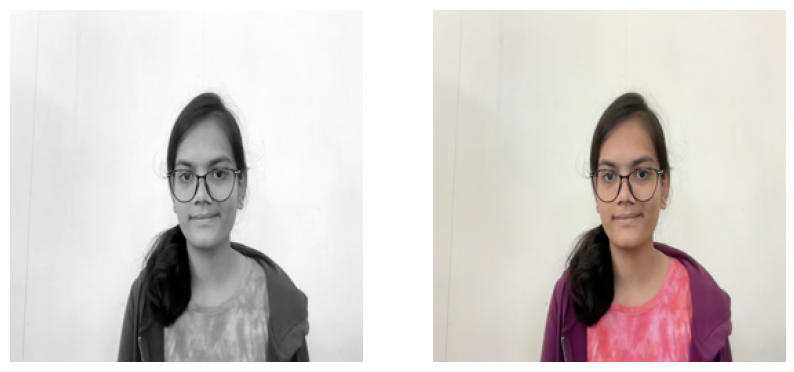

In [31]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_X[2], cmap='gray')
axes[1].imshow(test_Y[2])
for ax in axes:
    ax.axis('off')
plt.show()

In [34]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
test_X_reshaped = test_X.reshape(-1, s, s, 1)
mse = autoencoder.evaluate(test_X_reshaped, test_X_reshaped, verbose=0)
print(f"Model Mean Squared Error: {mse}")

Model Mean Squared Error: 0.6122851371765137
